In [1]:
import os
import argparse
from argparse import Namespace
import time
import json
import pickle
import torch
import numpy as np
import random

from train import train
from utils import get_simu_data

In [2]:
opts = Namespace(
	batch_size = 256,
	mode = 'train',
	lr = 5e-2,
	epochs = 200,
	grad_clip = False,
	mxAlpha = 4,
	mxBeta = 0.5,
	mxTemp = 1,
	lmbda = 1e-1,
	MMD_sigma = 1000,
	kernel_num = 10,
	matched_IO = False,
	latdim = 5,
	seed = 12
)

device = 'cuda:0'

torch.manual_seed(opts.seed)
np.random.seed(opts.seed)
random.seed(opts.seed)

# 1. load data

In [3]:
dataloader, dataloader2, dim, cdim, ptb_targets, nonlinear = get_simu_data(batch_size=opts.batch_size, mode=opts.mode)

100%|██████████| 5/5 [00:00<00:00, 6411.35it/s]


In [4]:
dataloader3, dim, cdim, ptb_targets, nonlinear = get_simu_data(batch_size=opts.batch_size, mode='test', perturb_targets=ptb_targets)

# 2. training

In [5]:
opts.dim = dim
if opts.latdim is None:
	opts.latdim = cdim
opts.cdim = cdim

In [6]:
# [2,3,1,4,0]
# [4,3,2,1,0]
# [0,2,1,3,4]) 
train(dataloader, opts, device, '../result/', log=True, simu=True, nonlinear=nonlinear, order=[0,1,2,3,4])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jqvicky. Use `wandb login --relogin` to force relogin


Training for 200 epochs...
Epoch 0: Loss=0.5483091431336444, MMD=3.397153612495603, MSE=0.49803947497502443, KL=5.4522780228670165,L1=0.5026966815862007
Epoch 10: Loss=0.3402681605554913, MMD=1.3278715617912755, MSE=0.0514373930519065, KL=19.4606314737011,L1=0.06304917185554498
Epoch 20: Loss=0.36442928580170514, MMD=0.09534505955497466, MSE=0.10932607770925129, KL=6.952241968730732,L1=0.10322918137271953
Epoch 30: Loss=0.5370555298699005, MMD=0.08185833480368947, MSE=0.172719814243455, KL=4.893635142557624,L1=0.18329890316062739
Epoch 40: Loss=0.6839806009681519, MMD=0.07043181320824816, MSE=0.22919768096772675, KL=4.189919535169198,L1=0.17351202283923253
Epoch 50: Loss=1.2151819705047406, MMD=0.2467467072221683, MSE=0.3672298021416428, KL=3.1651880580056053,L1=0.4051796959715195
Epoch 60: Loss=0.8641253212541342, MMD=0.05043597929011804, MSE=0.3579829976615279, KL=2.8113416630021826,L1=0.16230117766765786
Epoch 70: Loss=1.1168081189489696, MMD=0.10335752405695517, MSE=0.4501410753831

In [7]:
def kendall_tau_distance(perm1, perm2):
    if len(perm1) != len(perm2):
        raise ValueError("Permutations must have the same length.")

    distance = 0
    for i in range(len(perm1)):
        for j in range(i + 1, len(perm1)):
            if (perm1[i] < perm1[j] and perm2[i] > perm2[j]) or \
               (perm1[i] > perm1[j] and perm2[i] < perm2[j]):
                distance += 1

    return distance

kendall_tau_distance([0,1,2,3,4], [2,3,1,4,0])

6

# 3. evaluation 

In [8]:
savedir = '../result/' 

model = torch.load(f'{savedir}/best_model.pt')

## 3.1 graph

In [9]:
model.eval()
order = []
c_set = np.eye(5)
for i in range(5):
    c = c_set[i,:]
    c = torch.from_numpy(c).to(device).double().unsqueeze(0)

    bc,csz = model.c_encode(c, temp=1)
    order.append(bc.argmax().item())

print(order)

[0, 1, 2, 3, 4]


In [29]:
torch.triu(model.G, diagonal=1)

tensor([[ 0.0000e+00,  6.5912e-02, -5.6734e-03,  7.7172e-03,  1.8802e-03],
        [ 0.0000e+00,  0.0000e+00, -8.4931e-03, -4.3890e-06, -2.9855e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  7.5429e-03,  3.4560e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.3644e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],
       device='cuda:0', dtype=torch.float64, grad_fn=<TriuBackward0>)

In [11]:
threshold = [0.01]#np.arange(0,1,0.0001)
SHD = []

def structural_hamming_distance(adj_matrix1, adj_matrix2):
    shd = 0
    n = len(adj_matrix1)

    for i in range(n):
        for j in range(n):
            if adj_matrix1[i][j] != adj_matrix2[i][j]:
                shd += 1

    return shd


Gp_f = (abs(np.diag(np.ones(cdim - 1), 1)) > 0)
for t in threshold:
    G_f = (abs(torch.triu(model.G, diagonal=1).detach().cpu().numpy()[order,:][:,order])>t)
    shd = structural_hamming_distance(Gp_f, G_f)
    SHD.append(shd)

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5]),
 <BarContainer object of 10 artists>)

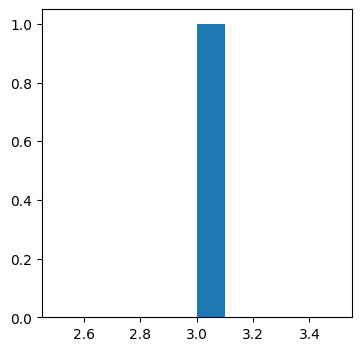

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.hist(SHD)

## 3.2 test training and single

In [13]:
from inference import evaluate_generated_samples

rmse, signerr, gt_y, pred_y, c_y, gt_x = evaluate_generated_samples(model, dataloader, device, 1, 1)

In [14]:
from utils import MMD_loss
from tqdm import tqdm

C_y = [','.join([str(l) for l in np.where(c_y[i]!=0)[0]]) for i in range(c_y.shape[0])]
loss =  MMD_loss(fix_sigma=1000, kernel_num=10)

mmd_loss = {}
rmse_loss = {}
r2 = {}
for i in range(len(C_y)//opts.batch_size):
	y = torch.from_numpy(gt_y[i*opts.batch_size:(i+1)*opts.batch_size])
	y_hat = torch.from_numpy(pred_y[i*opts.batch_size:(i+1)*opts.batch_size])
	c = C_y[i*opts.batch_size]
	if c in mmd_loss.keys():
		mmd_loss[c].append(loss(y_hat, y).item())
	else:
		mmd_loss[c] = [loss(y_hat, y).item()] 
        
# test
mmd_loss_summary = {}
for k in tqdm(mmd_loss.keys()):
	mmd_loss_summary[k] = (np.average(mmd_loss[k]), np.std(mmd_loss[k]))

100%|██████████| 5/5 [00:00<00:00, 11748.75it/s]


In [15]:
print('mmd')
print('mean', np.mean([i[0] for i in mmd_loss_summary.values()]))
print('ste', np.std([i[0] for i in mmd_loss_summary.values()])/np.sqrt(len(mmd_loss_summary.keys())))

mmd
mean 0.03837238996400031
ste 0.008028846917896878


## 3.3 test doubles

In [16]:
rmse, signerr, gt_y, pred_y, c_y, gt_x = evaluate_generated_samples(model, dataloader3, device, 1, 2)

In [17]:
from utils import MMD_loss
from tqdm import tqdm

C_y = [','.join([str(l) for l in np.where(c_y[i]!=0)[0]]) for i in range(c_y.shape[0])]
loss =  MMD_loss(fix_sigma=1000, kernel_num=10)

mmd_loss = {}
rmse_loss = {}
r2 = {}
for i in range(len(C_y)//opts.batch_size):
	y = torch.from_numpy(gt_y[i*opts.batch_size:(i+1)*opts.batch_size])
	y_hat = torch.from_numpy(pred_y[i*opts.batch_size:(i+1)*opts.batch_size])
	c = C_y[i*opts.batch_size]
	if c in mmd_loss.keys():
		mmd_loss[c].append(loss(y_hat, y).item())
	else:
		mmd_loss[c] = [loss(y_hat, y).item()] 
        
# test
mmd_loss_summary = {}
for k in tqdm(mmd_loss.keys()):
	mmd_loss_summary[k] = (np.average(mmd_loss[k]), np.std(mmd_loss[k]))

100%|██████████| 10/10 [00:00<00:00, 23603.29it/s]


In [18]:
print('mmd')
print('mean', np.mean([i[0] for i in mmd_loss_summary.values()]))
print('ste', np.std([i[0] for i in mmd_loss_summary.values()])/np.sqrt(len(mmd_loss_summary.keys())))

mmd
mean 0.0873145686858263
ste 0.00882843405499783


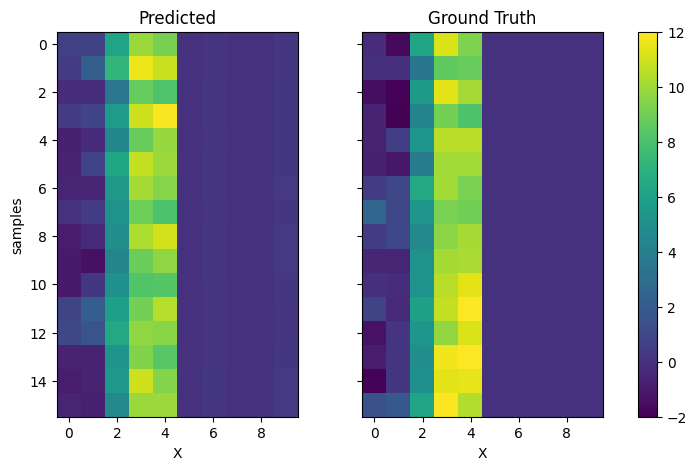

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
axs[0].imshow(pred_y[1024:1024+16,:], vmin=-2, vmax=12)
axs[0].set_title('Predicted')
im = axs[1].imshow(gt_y[1024:1024+16,:], vmin=-2, vmax=12)
axs[1].set_title('Ground Truth')
axs[0].set_ylabel('samples')
axs[0].set_xlabel('X')
axs[1].set_xlabel('X')
fig.subplots_adjust(right=1)
fig.colorbar(im, ax=axs.ravel().tolist())
fig.savefig('./figures/simu-output.pdf')